In [1]:
---
title: Understanding RNA-seq differential expression
mathjax: true
toc: true
toc_sticky: true
toc_label:  'Contents'
categories: [data science, statistics, bioinformatics]
---

SyntaxError: invalid syntax (<ipython-input-1-b35ce41a640a>, line 1)

*Why can't we just use a t-test?*

When I performed single-cell RNA-seq experiments, I did not have much statistics knowledge. However, I knew that we were looking for differences between certain groups. There were fancy statistical methods for evaluating these differences but I  wondered why we could not use a simple t-test as I did for other experiments in the lab. In addition, it seems like there are so many methods for single-cell differential expression. [Soneson and Robinson](https://www.nature.com/articles/nmeth.4612) had evaluated the impact of the differential expression methods. My aim in this post is to not compare methods, but to start with my naive question and go step-by-step into why other methods were created. We will use a dataset from an, ahem, [randomly chosen study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4838832/).

The reasons for having other differential expression methods can be broken down roughly into these reasons:
- Distribution of the data are not weird and not valid for a t-test
- Library sequencing
- Assumptions of t-test are not met
- What about non-parametric methods?



In [79]:
# Load packages for coding examples
import os
import pandas as pd
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
from plotnine import *   # ggplot syntax
import random
import seaborn as sns
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import norm

sns.set_context('talk')   # visual theme

In [62]:
os.listdir(data_dir)

['.Rhistory',
 'corrected_deseq_EE_Fos_022015_p05.txt',
 'FosNov15_WS.RData',
 'EE_allsamplesMinusApuaOutliers_deseq_sl_150227.csv',
 'DESeq2_logFCPosisFosHigh_techoutlierremoved_03042014_sl.xlsx',
 'sample_sheetFos.txt',
 'genes_fosTPM.csv',
 'DESeq2_logFCPosisFosHigh_techoutlierremoved_03042014_sl.txt',
 '.RData',
 'EE_allsamplesMinusApuaOutliers_deseq_sl_150227.txt',
 'RSEM_geneSymbol_tpm_141204_allsamples.txt',
 'APstats.csv',
 'corrected_deseq_EE_Fos_022015_edit.xlsx',
 'corrected_deseq_EE_Fos_022015.txt']

# Import the data


In [4]:
# Transpose the matrix to put samples as rows
data_dir = '/Users/lacar/Documents/Gage_Lab/AnalysisOfSequencing/SaraRSEM_output/update15_0225/'
tpm = pd.read_csv(data_dir + 'RSEM_geneSymbol_tpm_141204_allsamples.txt', sep=' ').T

In [5]:
tpm.head()

,0610005C13Rik,0610007P14Rik,0610009B22Rik,0610009E02Rik,0610009L18Rik,0610009O20Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012D04Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11a,Zyg11b,Zyx,Zzef1,Zzz3
nc_ui_ti_C10_141204,6.54,652.15,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,22.39,0.0,0.0,0.00,0.0,0.00,0.0,22.03,0.00
nc_ui_ti_C11_141204,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,69.07,0.00
nc_ui_ti_C12_141204,4.98,29.90,0.0,0.0,0.0,0.0,0.0,173.27,0.0,0.0,...,0.0,2905.22,0.0,0.0,0.00,0.0,0.00,0.0,0.00,5.87
nc_ui_ti_C7_141204,4.45,56.36,0.0,0.0,0.0,0.0,0.0,0.00,2.3,0.0,...,0.0,156.51,0.0,0.0,2.91,0.0,200.94,0.0,62.27,0.00
nc_ui_ti_C8_141204,0.00,86.04,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.0,2.99,0.00


In [109]:
metrics = pd.read_csv(data_dir + 'APstats.csv', index_col=0)

# parse sample name 
metrics = pd.merge(metrics, metrics.copy().index.to_series().str.split('_', expand=True).iloc[:, 0:3].copy(),
                   how='inner', left_index=True, right_index=True)
metrics.head()

,raw,cutadapt,mm10_mapped,mm10_uniquely_mapped,ercc_mapped,RSEMnoGenesTPM1,0,1,2
sample_name,,,,,,,,,
nc_ui_ti_C10_141204,5135738,3571561,773917,733702,2770807,3784,nc,ui,ti
nc_ui_ti_C11_141204,5323516,5027164,61238,41229,4953005,293,nc,ui,ti
nc_ui_ti_C12_141204,5876513,3618094,881543,833854,2711982,3875,nc,ui,ti
nc_ui_ti_C7_141204,5515921,4235227,991121,941522,3204349,4290,nc,ui,ti
nc_ui_ti_C8_141204,4197150,3367538,684407,649333,2651480,3941,nc,ui,ti


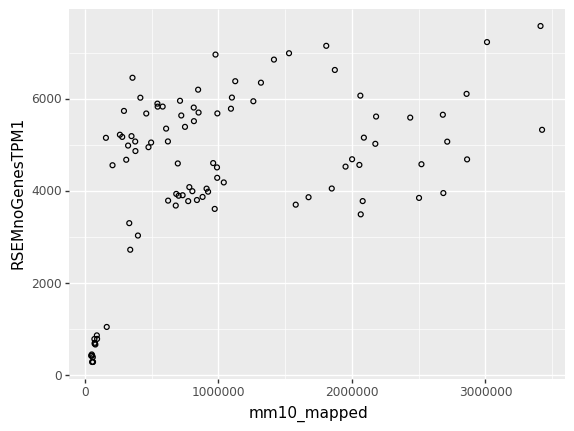

<ggplot: (-9223372036508395029)>

In [110]:
(
    ggplot(metrics, aes("mm10_mapped", "RSEMnoGenesTPM1"))
    + geom_point(fill="none")
)

## Filter data

Keep samples with at least 2000 genes.

In [84]:
samples2keep = metrics[metrics['RSEMnoGenesTPM1'] > 2000].index

Remove genes that do not have any reads assigned to them.

In [86]:
genes2keep = tpm.sum(axis=0) > 0

Generate a new matrix.

In [87]:
tpm_filt = tpm.loc[samples2keep, genes2keep]

In [88]:
print('Remaining number of samples and genes: ', tpm_filt.shape)

Remaining number of samples and genes:  (82, 24345)


## Inspect distribution of raw TPM values

In [89]:
random_gene_columns = random.sample(range(tpm_filt.shape[1]), 7) + [tpm_filt.columns.get_loc('Prox1')]

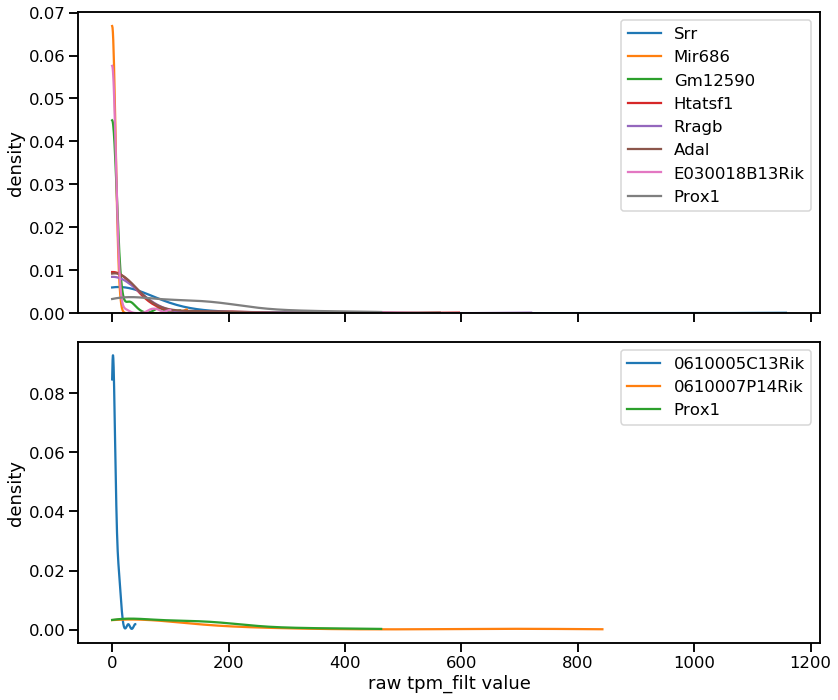

In [90]:
## Look at the distribution of a few randomly chosen genes and Prox1
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for gene_col in random_gene_columns:
    sns.kdeplot(tpm_filt.iloc[:, gene_col], cut=0, ax=ax1, label=tpm_filt.columns[gene_col])

ax1.set_ylabel('density')
ax1.legend()

## Look at the distribution of a some selected genes
selected_gene_columns = list(range(2)) + [tpm_filt.columns.get_loc('Prox1')]

for gene_col in selected_gene_columns:
    sns.kdeplot(tpm_filt.iloc[:, gene_col], cut=0, label=tpm_filt.columns[gene_col], ax=ax2)

ax2.set_xlabel('raw tpm_filt value')
ax2.set_ylabel('density')
ax2.legend()

plt.tight_layout()

Wow, what a horrible plot. We see a bunch of zeros but from the scale we can surmise that there are some samples with high TPM values. Nevertheless, this is a very unsatisfying. For this blog post, showing how the raw distribution helps justify the later steps.

Note that the density plot can take on negative TPM values if the `cut` parameter is not set in `kdeplot`. This seaborn function uses kernel density estimation to produce the plot. See [here](https://clauswilke.com/dataviz/histograms-density-plots.html) and [here](https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0) for great explanations of what a kernel density estimation is. Also, in the course of writing this, I upgraded seaborn from 0.9 to 0.11 so that I can refer to the documentation. There were some differences with between the (now deprecated) `distplot` function, `histplot`, `displot`, and `kdeplot`, the latter of which I chose to use above. It was a little bit frustrating navigating these differences so I hope I can spare you my trouble.

## Inspect distribution of transformed TPM values

One thing we can do is plot the x-axis on a log scale. This can be done easily as a parameter in the `seaborn` call by setting `log_scale=True`.

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarnin

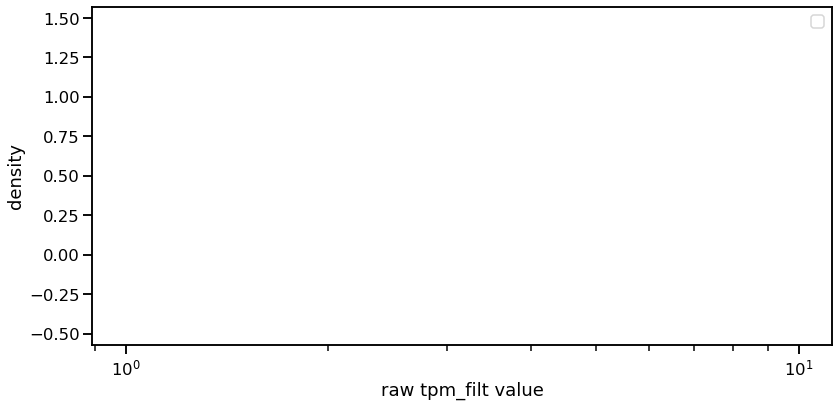

In [91]:
## Look at the distribution of a few randomly chosen genes and Prox1
f, (ax1) = plt.subplots(1, 1, figsize=(12, 6), sharex=True)

for gene_col in random_gene_columns:
    sns.kdeplot(tpm_filt.iloc[:, gene_col], cut=0, log_scale=True, ax=ax1, label=tpm_filt.columns[gene_col])

ax1.set_xlabel('raw tpm_filt value')
ax1.set_ylabel('density')
ax1.legend()

plt.tight_layout()

We encounter an issue here that is described by the error message: `divide by zero encountered in log10`. One way people get around this is to add 1 to each value. In addition, log with base 2 seems to be more common in RNA-seq.

In [92]:
tpm_filt_log2 = np.log2(tpm_filt+1)

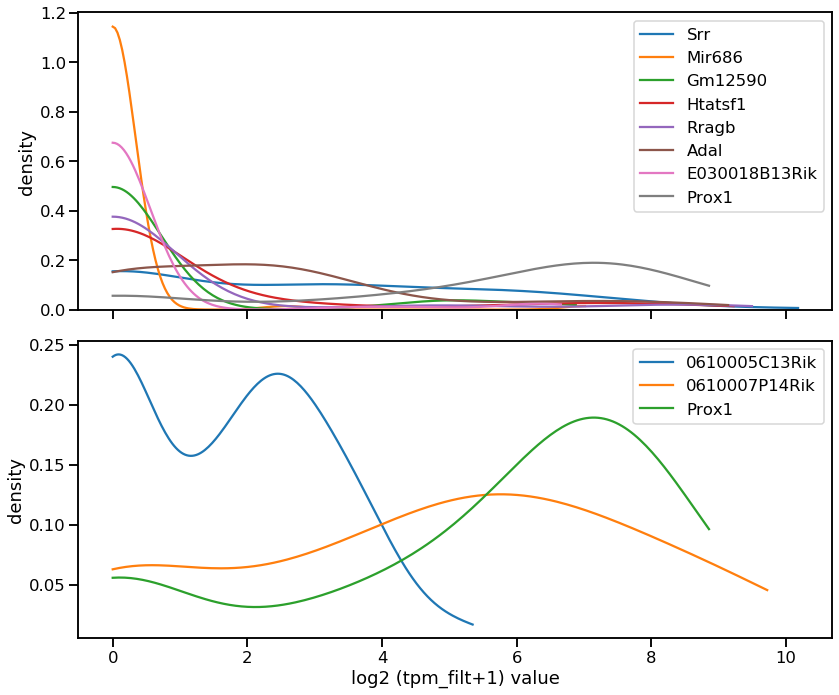

In [114]:
## Look at the distribution of a few randomly chosen genes and Prox1
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

for gene_col in random_gene_columns:
    sns.kdeplot(tpm_filt_log2.iloc[:, gene_col], cut=0, ax=ax1, label=tpm_filt_log2.columns[gene_col])

ax1.set_ylabel('density')
ax1.legend()

## Look at the distribution of a some selected genes
selected_gene_columns = list(range(2)) + [tpm_filt_log2.columns.get_loc('Prox1')]

for gene_col in selected_gene_columns:
    sns.kdeplot(tpm_filt_log2.iloc[:, gene_col], cut=0, label=tpm_filt_log2.columns[gene_col], ax=ax2)

ax2.set_xlabel('log2 (tpm_filt+1) value')
ax2.set_ylabel('density')
ax2.legend()

plt.tight_layout()

Interesting. While the top plot still has many samples that have low values, we see that the x-axis is on a more reasonable scale that we can appreciate. Great. Now what?

# What does a group difference look like?

In [134]:
# Limit to Prox1 and Arc

tpm_filt_log2_lim = tpm_filt_log2.loc[:, ['Prox1', 'Arc']].copy()
tpm_filt_log2_lim = pd.merge(metrics[[0,1,2]], tpm_filt_log2_lim, how='inner', left_index=True, right_index=True)
tpm_filt_log2_lim.rename({0:'group1_var', 1:'group2_var', 2:'group3_var'}, axis=1, inplace=True)
tpm_filt_log2_lim

,group1_var,group2_var,group3_var,Prox1,Arc
sample_name,,,,,
nc_ui_ti_C10_141204,nc,ui,ti,7.451623,9.180605
nc_ui_ti_C12_141204,nc,ui,ti,5.334497,11.003932
nc_ui_ti_C7_141204,nc,ui,ti,0.000000,10.471635
nc_ui_ti_C8_141204,nc,ui,ti,7.018923,8.283042
nc_ui_ti_C9_141204,nc,ui,ti,7.303872,9.957305
...,...,...,...,...,...
nm_ux_tn_F2_141204,nm,ux,tn,4.941106,0.000000
nm_ux_tn_F3_141204,nm,ux,tn,4.008092,0.000000
nm_ux_tn_F4_141204,nm,ux,tn,7.314697,0.678072


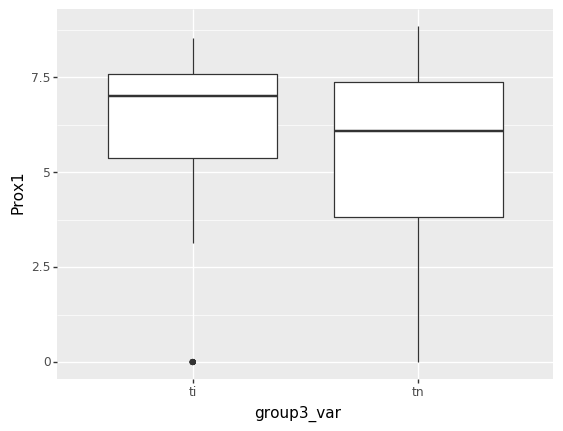

<ggplot: (-9223372036507429351)>

In [144]:
(
    ggplot(tpm_filt_log2_lim, aes(x="group3_var", y="Prox1"))
    + geom_boxplot()
)

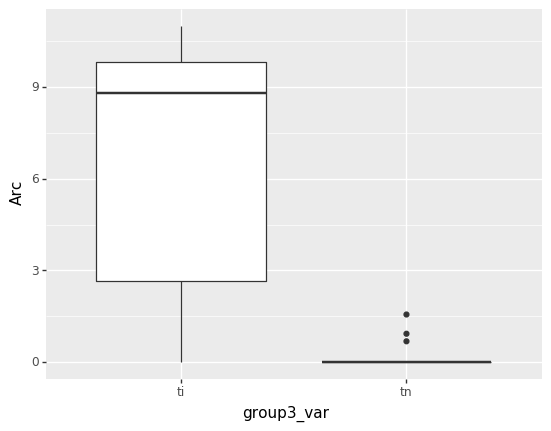

<ggplot: (-9223372036506745165)>

In [145]:
(
    ggplot(tpm_filt_log2_lim, aes(x="group3_var", y="Arc"))
    + geom_boxplot()
)